<img src = "https://drive.google.com/uc?export=view&id=1FNyRcLn_ZqLm263UvW1gEDW1_QaTr9hG" alt = "Encabezado MLDS" width = "100%">  </img>

#**Applied Project (MLDS-5): An Automated White Blood Cells Classification Using Transfer Learning and Fine tuning Techniques**
---

**Import Libraries:**


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random

plt.style.use("ggplot")
# We select a seed for the RNG
tf.random.set_seed(0)
np.random.seed(0)
import gdown
import os

**Load the Images:**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Data Loading

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data")

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Train",
    validation_split = 0.2,
    subset = "validation",
    seed = 123)

ds_test_A = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Test-A")

ds_test_B = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Test-B")

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Train",
    validation_split = 0.2,
    subset="validation",
    seed = 123)

Found 16633 files belonging to 3 classes.
Found 10175 files belonging to 5 classes.
Using 2035 files for validation.
Found 4339 files belonging to 5 classes.
Found 2119 files belonging to 2 classes.
Found 10175 files belonging to 5 classes.
Using 2035 files for validation.


**File Paths:**

In [6]:
train_path = "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Train"
test_A_path = "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Test-A"
test_B_path = "/content/gdrive/MyDrive/Colab Notebooks/MLDS - UNAL/Deep Learning (MLDS 5)/Applied Project/Data/WBC_Data/Test-B"

Label Distribution within the **_train dataset:_**

In [7]:
def label_dist(file_path):
  # Initialize an empty dictionary to store the label counts
  label_counts = {}
  for dirpath, dirnames, filenames in os.walk(file_path):
    label = os.path.basename(dirpath)

    if label == os.path.basename(file_path):
      continue
    # count the number of files in the current subdirectory
    num_files = len(filenames)
    # update the label counts in the dictionary
    label_counts[label] = num_files

  return label_counts

In [8]:
label_distribution_train = label_dist(train_path)

# Print label distribution
for label, count in label_distribution_train.items():
  print(f'{label}: {count} images')

Basophil: 212 images
Eosinophil: 744 images
Monocyte: 561 images
Lymphocyte: 2427 images
Neutrophil: 6231 images


Label Distribution **_Test_A Dataset:_**

In [9]:
label_distribution_testA = label_dist(test_A_path)

# Print label distribution
for label, count in label_distribution_testA.items():
  print(f'{label}: {count} images')

Basophil: 89 images
Lymphocyte: 1034 images
Eosinophil: 322 images
Monocyte: 234 images
Neutrophil: 2660 images


Label Distribution **_Test_B Dataset:_**

In [10]:
label_distribution_testB = label_dist(test_B_path)

# Print label distribution
for label, count in label_distribution_testB.items():
  print(f'{label}: {count} images')

Lymphocyte: 148 images
Neutrophil: 1971 images


###**Data Augmentation**
---

Create an object **generator** using the `ImageDataGenerator`function:

In [11]:
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import shuffle
from tensorflow import keras


batch_size = 32
image_size = (224, 224)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                  width_shift_range = 0.05,
                                                                  height_shift_range = 0.05,
                                                                  horizontal_flip = True,
                                                                  vertical_flip = True,
                                                                  validation_split = 0.2)

#we do not apply the same augmentation process to both validation and test subsets.

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                validation_split = 0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_aug = train_generator.flow_from_directory(directory = train_path,
                                         subset = 'training',
                                         batch_size = batch_size,
                                         shuffle = True,
                                         class_mode = 'categorical',
                                         target_size = image_size)

val_aug = val_generator.flow_from_directory(directory = train_path,
                                         subset = 'validation',
                                         batch_size = batch_size,
                                         shuffle = True,
                                         class_mode = 'categorical',
                                         target_size = image_size)

test_A_aug = test_generator.flow_from_directory(directory = test_A_path,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         class_mode = 'categorical',
                                         target_size = image_size)

test_B_aug = test_generator.flow_from_directory(directory = test_B_path,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         class_mode = 'categorical',
                                         target_size = image_size)

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.
Found 2119 images belonging to 2 classes.


###**Visualization**
---

Visualize some examples from the dataset:

In [12]:
import tensorflow_datasets as tfds

batch_size = 32
dataset_name = ds_train
class_names = ds_train.class_names

dataset_name_val_A = ds_test_A
class_names_A = ds_test_A.class_names

dataset_name_val_B = ds_test_B
class_names_B = ds_test_B.class_names

dataset_name_val = ds_validation
class_names_val = ds_validation.class_names

print(f'Labels in Train directory: {class_names}')
print(f'Labels in Test-A directory: {class_names_A}')
print(f'Labels in Test-A directory: {class_names_B}')
print(f'Labels in Validation directory: {class_names_val}')

Labels in Train directory: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
Labels in Test-A directory: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
Labels in Test-A directory: ['Lymphocyte', 'Neutrophil']
Labels in Validation directory: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


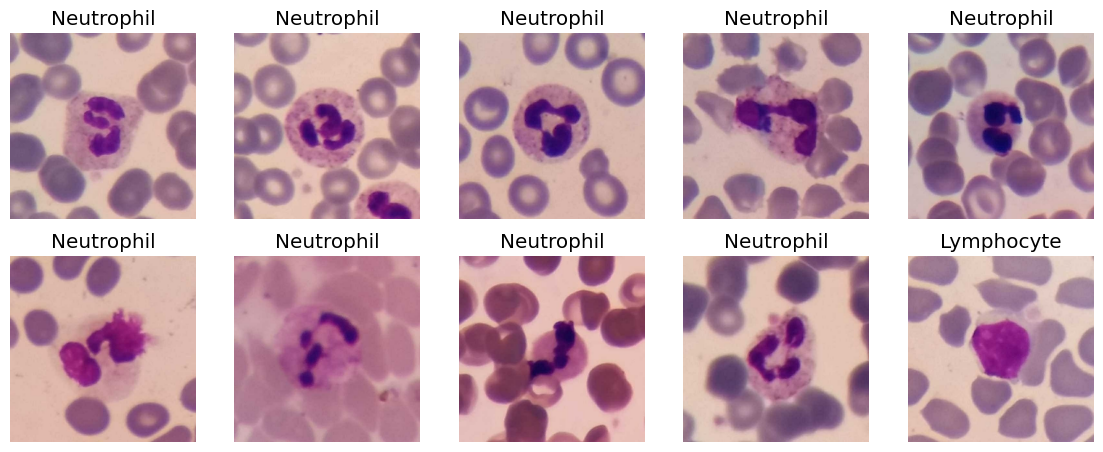

In [13]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize = (14, 14))
sample_size = 10 # set the number of random images to display

for images, labels in ds_train.take(1):
  random_indices = random.sample(range(len(images)), sample_size)

  for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    plt.title(class_names[labels[idx]])
    plt.axis('off')

plt.show()

# **Training and Validation**
---



## **1. Model Training and Hyperparameters Selection**
---

We previously selected the pre-trained [*ResNet50V2*](https://keras.io/api/applications/resnet/#resnet50v2-function) model for *hematological* image classification. In the present notebook, we will train, select the model hyperparameters and implement/compare both Transfer Learning and fine tuning techniques.

**Note:** As in this case we are working with a pre-trained model, implementing a transfer learning and fine tuning approach, the hyperparameters selection/evaluation is already set by the applied model in the present study ([*ResNet50V2*](https://keras.io/api/applications/resnet/#resnet50v2-function)).    

###**1.1 Model Definition (Transfer Learning)**
---
Define the **transfer learning model** (`tf_model`):

In [14]:
def tl_model(train_base_model, units, dropout):
  # Fix a seed for reproductibility purposes
  np.random.seed(0)
  tf.keras.utils.set_random_seed(0)
  # Define the EfficientNetB4 model
  extractor = tf.keras.applications.VGG16(weights = 'imagenet',
                                                 include_top = False,
                                                 input_shape = (224, 224, 3))

  #Define whether we freeze the extractor model or not
  for layer in extractor.layers:
    layer.trainable = train_base_model

  # create a pooling layer to consolidate the feature maps extracted from
  # the extractor layer
  pool = tf.keras.layers.GlobalAveragePooling2D()(extractor.output)
  # add a dense layer
  dense = tf.keras.layers.Dense(units = units, activation = 'relu')(pool)
  # add a dropout layer for regularization
  drop = tf.keras.layers.Dropout(dropout)(dense)
  # output layer with the corresponding number of categories (units = 5) and softmax activation
  output = tf.keras.layers.Dense(units = 5, activation = 'softmax')(drop)
  # Transfer Learning Model
  model = tf.keras.models.Model(inputs = [extractor.input], outputs = [output])
  return model

In [15]:
#Model Summary
model = tl_model(train_base_model = False,
                         units = 64,
                         dropout = 0.2)
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

To better visualize the model architecture:

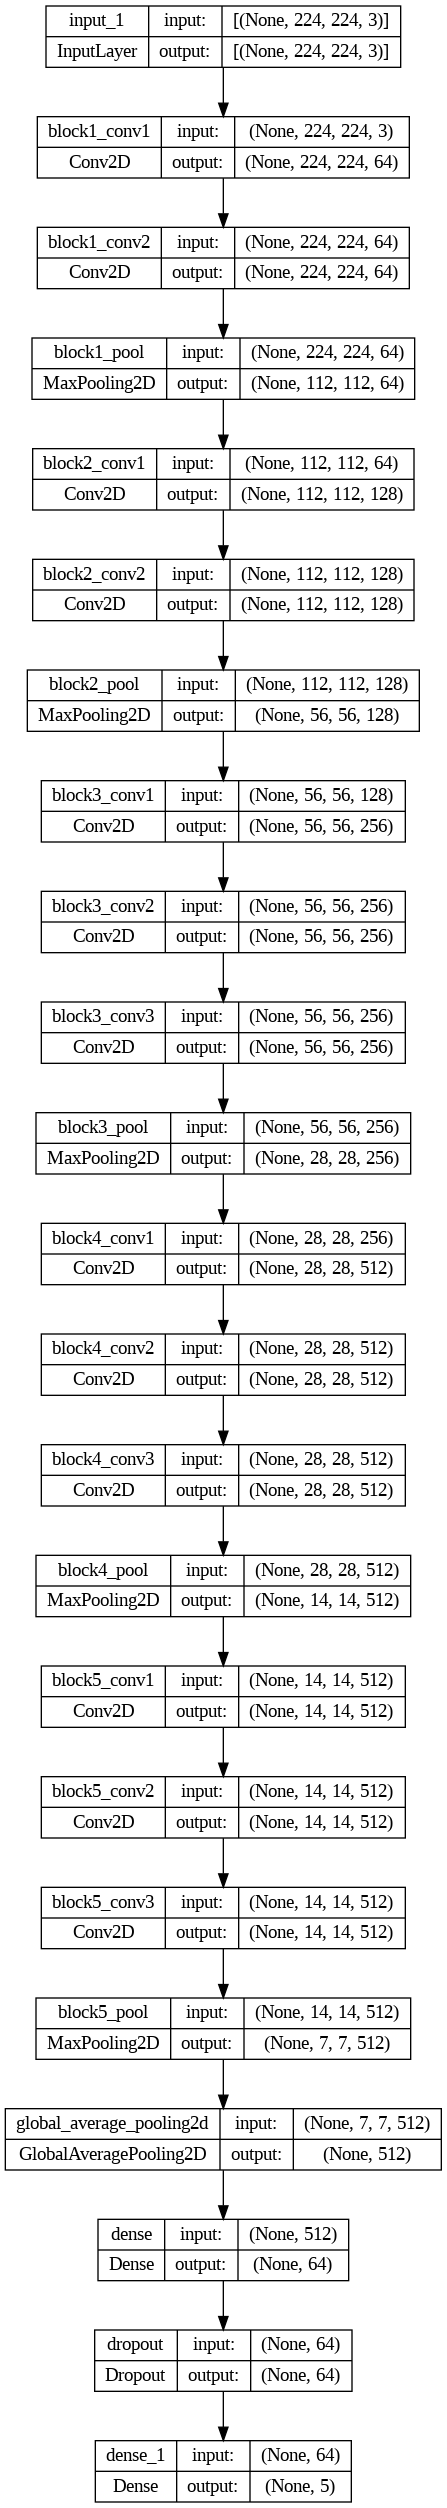

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

###**1.2 Compile the model**
---
Define the `compile_model` function:

In [17]:
from keras.src.backend import categorical_crossentropy

def compile_model(model, l_r, metrics):

  # Fix a seed for reproductibility purposes
  np.random.seed(0)
  tf.keras.utils.set_random_seed(0)

  model.compile(loss = 'categorical_crossentropy',
                optimizer  = tf.optimizers.Adam(learning_rate = l_r),
                metrics = metrics)

  return model

In [18]:
# Compile the Model

model = compile_model(model = model,
                      l_r = 1e-3,
                      metrics = ['accuracy'])

model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

###**1.3 Model Training**
---
`train_model` function:

In [19]:
def train_model(model, train_aug, val_aug, epochs, weights):

  # Fix a seed for reproductibility purposes
  np.random.seed(0)
  tf.keras.utils.set_random_seed(0)

  best_callback = tf.keras.callbacks.ModelCheckpoint(filepath = weights,
                                                     monitor = 'val_loss',
                                                     verbose = True,
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     mode = 'min')

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                    min_delta = 0.001,
                                                    patience = 5,
                                                    mode = 'min',
                                                    restore_best_weights = True,
                                                    verbose = 1)

  history = model.fit(x = train_aug,
                      validation_data = val_aug,
                      steps_per_epoch = len(train_aug),
                      validation_steps = len(val_aug),
                      epochs = epochs,
                      callbacks = [best_callback, early_stopping],
                      verbose = 1)

  return model, history

In [ ]:
# Model Training:

# Set the number of epochs
epochs = 15


#Initialize the transfer learning model
model = tl_model(train_base_model=False,
                              units = 64,
                              dropout = 0.2)
#Compile the model
model = compile_model(model = model,
                          l_r = 1e-3,
                          metrics = ['accuracy'])

# Loop through the epochs and train the model

#for i in range(epochs):

model_tl, history = train_model(model = model,
                                train_aug = train_aug,
                                val_aug = val_aug,
                                epochs = epochs, # Train for 1 epoch at a time
                                weights='transfer_learning.h5')

  #Save the model weights after each epoch
model_tl.save(f'./model_tl/model_tl.h5')

###**1.3.1 Model Training (Fine Tuning)**
---



###***Warming Up***
---
We start training only through a maximum of 7 *epochs* the added classification layers, by setting up a learning rate of $10^{-3}$. Following, we save the best model `warming_up.h5` to then, start from this point when implementing _Fine Tuning_.  

In [ ]:
# TEST CELL

# Set the number of epochs
epochs = 7
# set the batch size for training
batch_size = 32

#Initialize the transfer learning model
model = tl_model(train_base_model=False,
                              units = 64,
                              dropout = 0.2)
#Compile the model
model = compile_model(model = model,
                          l_r = 1e-3,
                          metrics = ['accuracy'])

# Loop through the epochs and train the model

#for i in range(epochs):

model_wup, history = train_model(model = model,
                                train_aug = train_aug,
                                val_aug = val_aug,
                                epochs = epochs,
                                batch_size = batch_size,
                                weights='warming_up.h5')

#Save the model weights
model_wup.save(f'./model_wup/model_wup.h5')

###***Fine Tuning***
---

We load the weights from the `model_wup_epoch{}` and thus, decrease the learning rate to $10^{-5}$, by training all the layers within the model:

In [ ]:
# Set the number of epochs
epochs = 15


model = model.load_weights("model_wup_epoch---") # Depending on the best model obtained in the previous warming up
#Initialize the transfer learning model
model = tl_model(train_base_model=True, # Enable the training of the extractor layer.
                              units = 64,
                              dropout = 0.2)
#Compile the model
model = compile_model(model = model,
                          l_r = 1e-5, # Reduce the learning rate to 10^-5
                          metrics = ['accuracy'])

# Loop through the epochs and train the model



model_ft, history_ft = train_model(model = model,
                                train_aug = train_aug,
                                val_aug = val_aug,
                                epochs = epochs, # Train for 1 epoch at a time
                                batch_size = batch_size,
                                weights='fine_tuning.h5')

#Save the model weights
model_ft.save(f'./model_ft/model_ft.h5')

###**1.4 Learning Curves (Transfer Learning)**
---
Curves of the learning rate:

*Accuracy/Loss vs Epochs*

In [ ]:
# Accuracy Plot Curves
plt.figure(figsize = [10, 5])
plt.subplot(121)
plt.plot(history.history['accuracy'], 'r', linewidth = 1.5)
plt.plot(history.history['val_accuracy'], 'b', linewidth = 1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 10)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves (Transfer Learning)', fontsize = 16)
plt.subplot(122)
plt.plot(history.history['loss'], 'r', linewidth = 1.5)
plt.plot(history.history['val_loss'], 'b', linewidth = 1.5)
plt.legend(['Training Loss', 'Validation Loss'], fontsize = 10)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss Curves (Transfer Learning)', fontsize = 16)
plt.show();

###**1.4 Learning Curves (Fine Tuning)**
---

In [ ]:
# Accuracy Plot Curves
plt.figure(figsize = [10, 5])
plt.subplot(121)
plt.plot(history_ft.history['accuracy'], 'r', linewidth = 1.5)
plt.plot(history_ft.history['val_accuracy'], 'b', linewidth = 1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 10)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves (Fine Tuning)', fontsize = 16)
plt.subplot(122)
plt.plot(history_ft.history['loss'], 'r', linewidth = 1.5)
plt.plot(history_ft.history['val_loss'], 'b', linewidth = 1.5)
plt.legend(['Training Loss', 'Validation Loss'], fontsize = 10)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss Curves (Fine Tuning)', fontsize = 16)
plt.show();

## **2. Evaluation and Model Application**
---

Implementation of the `classification_report` method:

We compute the predicted classes using the model trained by transfer learning, and then display the classification report.

###**2.1 Evaluation and Model Application (Transfer Learning)**
---

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predicted_classes_A = np.argmax(model_tl.predict(test_A_aug), axis = 1)
predicted_classes_B = np.argmax(model_tl.predict(test_B_aug), axis = 1)
#confusionmatrix = confusion_matrix(test_A_aug.classes, predicted_classes)
print(classification_report(test_A_aug.classes, predicted_classes_A))
print("-------------------------")
print(classification_report(test_A_aug.classes, predicted_classes_B))

In [ ]:
predicted_classes_A = np.argmax(model_ft.predict(test_A_aug), axis = 1)
predicted_classes_B = np.argmax(model_ft.predict(test_B_aug), axis = 1)
#confusionmatrix = confusion_matrix(test_A_aug.classes, predicted_classes)
print(classification_report(test_A_aug.classes, predicted_classes_A))
print("-------------------------")
print(classification_report(test_A_aug.classes, predicted_classes_B))

###**2.1.1 Testing Loss and Accuracy (Transfer Learning)**
---

Test the impleented model using the TL approach:

In [ ]:
loss, acc = model_tl.evaluate(test_A_aug)

In [ ]:
loss, acc = model_tl.evaluate(test_B_aug)

In [ ]:
loss, acc = model_ft.evaluate(test_A_aug)

In [ ]:
loss, acc = model_ft.evaluate(test_B_aug)

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/)
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*